In [1]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf
print(tf.__version__)
import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
AUTO = tf.data.experimental.AUTOTUNE

os.environ["CUDA_VISIBLE_DEVICES"]="6"   

2.5.0


In [2]:
# [image height, image width, focal length][down, right, backwards][-y, x, z]-z

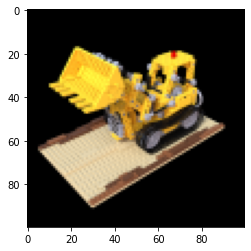

In [3]:
# Download the data if it does not already exist.
file_name = "tiny_nerf_data.npz"
data = np.load(file_name)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [4]:
focal

array(138.8888789)

In [5]:

# 각 픽셀을 통해서 광선을 쏠 수 있음. 광선 r(t)는 o + td로 여기서 t 는 매개변수 이고 o는 원점 임. d는 단위 방향 벡터임. 
# 광선 r(t)는 임의 점을 샘플링 하는데, 샘플 포인트는 각 고유한 위치(x,y,z)를 가지며, 광선에는 시야각이(theta, phi) 가 있음.
# 각 픽셀은 해당 광선이 있고, 광선은 별개의 지점에서 샘플링 됨.
# 샘플링 포인트는 Nerf의 모델에 대한 입력으로 사용됨. 그런다음 모델은 해당 지점의 RGB 색상과 볼륨 밀도를 예측하도록 요청됨. 


In [6]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.
    Args:
        x: The input coordinate.
    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)

In [7]:
def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(tf.range(width, dtype=tf.float32),
                       tf.range(height, dtype=tf.float32),
                       indexing="xy",)

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, - transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

In [8]:
def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

In [9]:
def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

In [10]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=128, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.nn.relu(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")
        self.ssim_metric = keras.metrics.Mean(name="psnr")
        
    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)
        ssim = tf.image.ssim(images, rgb, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        self.ssim_metric.update_state(ssim)
        
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result(), "ssim": self.ssim_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)
        
        ssim = tf.image.ssim(images, rgb, max_val=1.0, filter_size=11,
                                  filter_sigma=1.5, k1=0.01, k2=0.03)
        
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        self.ssim_metric.update_state(ssim)
        return {"loss": self.loss_tracker.result(), "@psnr": self.psnr_metric.result(), "@ssim": self.ssim_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric, self.ssim_metric]

In [11]:
filepath = './logs/my_model/'
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=50,verbose=0,mode="auto",baseline=None,restore_best_weights=False)
ckpt = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=True)

In [12]:
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            loss = logs["loss"]
            loss_list.append(loss)
            
            psnr = logs["psnr"]
            PSNR_list.append(psnr)
            
            ssim = logs["ssim"]
            SSIM_list.append(ssim)
            
            test_recons_images, depth_maps = render_rgb_depth(
                model=self.model.nerf_model,
                rays_flat=test_rays_flat,
                t_vals=test_t_vals,
                rand=True,
                train=False,
            )
            
            fig = plt.figure(figsize=(20,5))

            plt.subplots_adjust(hspace=0.3, wspace=0.1)

            gridshape=(3,3)

            ax1 = plt.subplot2grid(gridshape, loc=(0,0), rowspan=3, colspan=1)
            plt.imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
            ax1.set_title(f"Predicted Image: {epoch:03d}")

            ax2 = plt.subplot2grid(gridshape, loc=(0,1), rowspan=3, colspan=1)
            plt.imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
            ax2.set_title(f"Depth Map: {epoch:03d}")

            ax3 = plt.subplot2grid(gridshape, loc=(0,2), colspan=1)
            plt.plot(loss_list,label='val_loss')
            ax3.set_title(f"Loss Plot: {epoch:03d}")
            plt.legend()

            plt.subplot2grid(gridshape, loc=(1,2), colspan=1)
            plt.plot(PSNR_list,label='psnr')
            plt.legend()

            plt.subplot2grid(gridshape, loc=(2,2), colspan=1)
            plt.plot(SSIM_list,label='ssim')
            plt.legend()


            fig.savefig(f"images/{epoch:03d}.png")
            plt.show()
            plt.close()

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)

In [13]:
# Initialize global variables.
NUM_SAMPLES = 64
POS_ENCODE_DIMS = 32
BATCH_SIZE = 5
EPOCHS = 200

In [14]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (training_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO))

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (validation_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO))

In [15]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

In [16]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError())

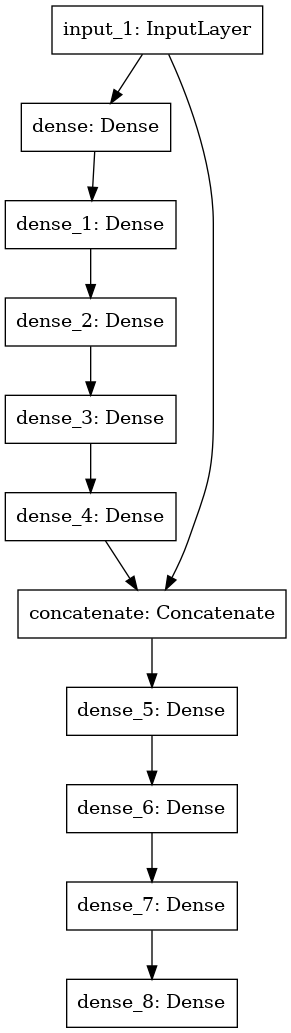

In [17]:
tf.keras.utils.plot_model(nerf_model)

[]

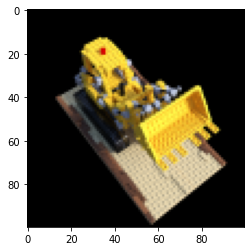

In [18]:
plt.imshow(test_imgs[2])
plt.plot()

In [18]:
nerf


NameError: name 'nerf' is not defined

Epoch 1/500
16/16 [==============================] - 71s 4s/step - loss: 0.0414 - psnr: 14.1810 - ssim: 0.0603 - val_loss: 0.0330 - val_psnr: 14.9777 - val_ssim: 0.1438


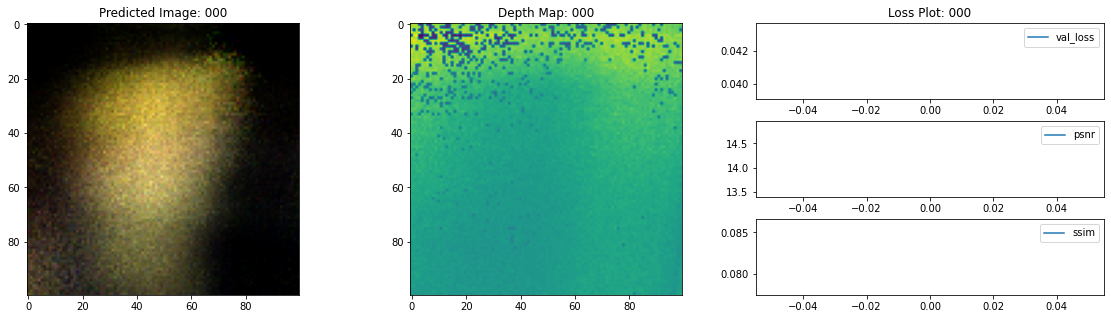

Epoch 2/500
16/16 [==============================] - 65s 4s/step - loss: 0.0304 - psnr: 15.4458 - ssim: 0.1713 - val_loss: 0.0292 - val_psnr: 15.5529 - val_ssim: 0.2661
Epoch 3/500
16/16 [==============================] - 62s 4s/step - loss: 0.0267 - psnr: 15.9552 - ssim: 0.2340 - val_loss: 0.0259 - val_psnr: 16.0136 - val_ssim: 0.2575
Epoch 4/500
16/16 [==============================] - 61s 4s/step - loss: 0.0257 - psnr: 16.1105 - ssim: 0.2674 - val_loss: 0.0242 - val_psnr: 16.3397 - val_ssim: 0.3196
Epoch 5/500
16/16 [==============================] - 62s 4s/step - loss: 0.0240 - psnr: 16.3990 - ssim: 0.2839 - val_loss: 0.0224 - val_psnr: 16.6524 - val_ssim: 0.3197
Epoch 6/500
16/16 [==============================] - 60s 4s/step - loss: 0.0227 - psnr: 16.6256 - ssim: 0.3148 - val_loss: 0.0217 - val_psnr: 16.7878 - val_ssim: 0.3598
Epoch 7/500
16/16 [==============================] - 60s 4s/step - loss: 0.0208 - psnr: 17.0235 - ssim: 0.3327 - val_loss: 0.0204 - val_psnr: 17.0052 - val

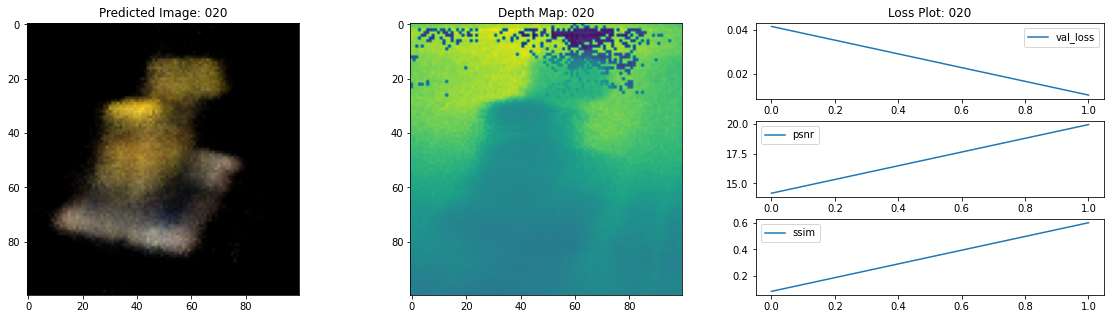

Epoch 22/500
16/16 [==============================] - 61s 4s/step - loss: 0.0100 - psnr: 20.1898 - ssim: 0.6129 - val_loss: 0.0097 - val_psnr: 20.2805 - val_ssim: 0.6322
Epoch 23/500
16/16 [==============================] - 59s 4s/step - loss: 0.0097 - psnr: 20.3074 - ssim: 0.6216 - val_loss: 0.0101 - val_psnr: 20.0303 - val_ssim: 0.5991
Epoch 24/500
16/16 [==============================] - 61s 4s/step - loss: 0.0094 - psnr: 20.4439 - ssim: 0.6246 - val_loss: 0.0094 - val_psnr: 20.4240 - val_ssim: 0.6547
Epoch 25/500
16/16 [==============================] - 61s 4s/step - loss: 0.0094 - psnr: 20.4803 - ssim: 0.6425 - val_loss: 0.0095 - val_psnr: 20.3028 - val_ssim: 0.6364
Epoch 26/500
16/16 [==============================] - 61s 4s/step - loss: 0.0094 - psnr: 20.4496 - ssim: 0.6389 - val_loss: 0.0094 - val_psnr: 20.3477 - val_ssim: 0.6332
Epoch 27/500
16/16 [==============================] - 61s 4s/step - loss: 0.0089 - psnr: 20.7193 - ssim: 0.6377 - val_loss: 0.0086 - val_psnr: 20.7739

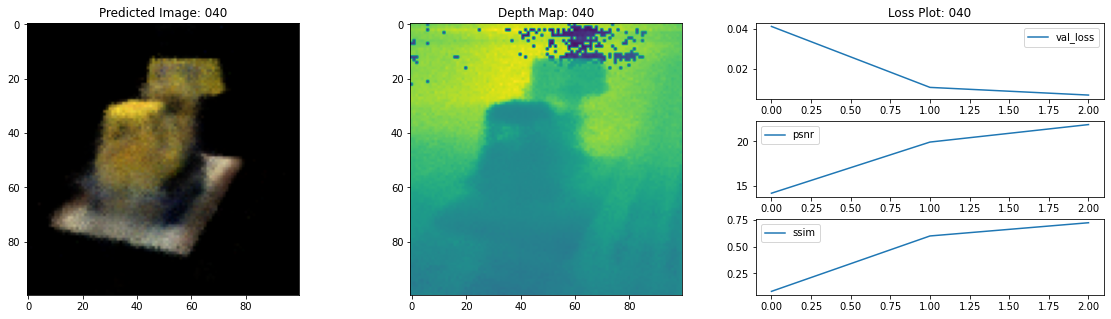

Epoch 42/500
16/16 [==============================] - 59s 4s/step - loss: 0.0067 - psnr: 21.8976 - ssim: 0.7238 - val_loss: 0.0068 - val_psnr: 21.8421 - val_ssim: 0.7238
Epoch 43/500
16/16 [==============================] - 60s 4s/step - loss: 0.0067 - psnr: 21.9202 - ssim: 0.7263 - val_loss: 0.0070 - val_psnr: 21.6421 - val_ssim: 0.7249
Epoch 44/500
16/16 [==============================] - 59s 4s/step - loss: 0.0066 - psnr: 21.9916 - ssim: 0.7330 - val_loss: 0.0077 - val_psnr: 21.3842 - val_ssim: 0.7315
Epoch 45/500
16/16 [==============================] - 61s 4s/step - loss: 0.0067 - psnr: 21.9519 - ssim: 0.7304 - val_loss: 0.0068 - val_psnr: 21.8817 - val_ssim: 0.7319
Epoch 46/500
16/16 [==============================] - 59s 4s/step - loss: 0.0065 - psnr: 22.0654 - ssim: 0.7354 - val_loss: 0.0066 - val_psnr: 22.0037 - val_ssim: 0.7400
Epoch 47/500
16/16 [==============================] - 60s 4s/step - loss: 0.0062 - psnr: 22.2316 - ssim: 0.7429 - val_loss: 0.0063 - val_psnr: 22.1463

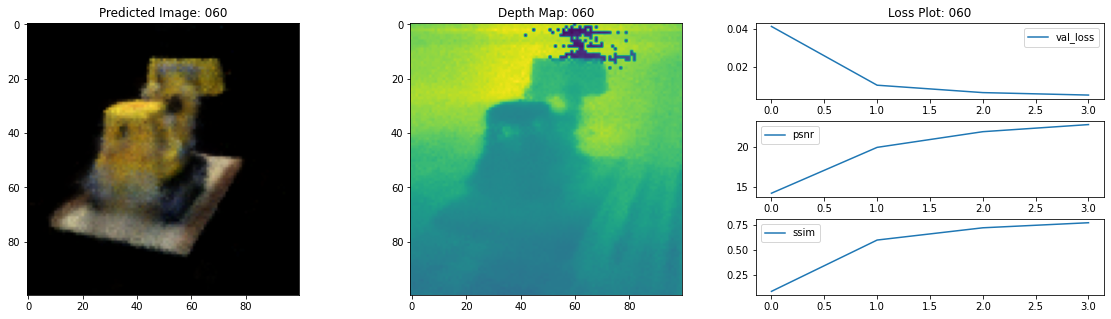

Epoch 62/500
16/16 [==============================] - 60s 4s/step - loss: 0.0054 - psnr: 22.8414 - ssim: 0.7750 - val_loss: 0.0058 - val_psnr: 22.4518 - val_ssim: 0.7709
Epoch 63/500
16/16 [==============================] - 60s 4s/step - loss: 0.0052 - psnr: 23.0213 - ssim: 0.7845 - val_loss: 0.0055 - val_psnr: 22.6959 - val_ssim: 0.7712
Epoch 64/500
16/16 [==============================] - 60s 4s/step - loss: 0.0051 - psnr: 23.1033 - ssim: 0.7852 - val_loss: 0.0056 - val_psnr: 22.6841 - val_ssim: 0.7777
Epoch 65/500
16/16 [==============================] - 61s 4s/step - loss: 0.0050 - psnr: 23.1358 - ssim: 0.7903 - val_loss: 0.0054 - val_psnr: 22.7640 - val_ssim: 0.7778
Epoch 66/500
16/16 [==============================] - 60s 4s/step - loss: 0.0050 - psnr: 23.2051 - ssim: 0.7919 - val_loss: 0.0053 - val_psnr: 22.8516 - val_ssim: 0.7725
Epoch 67/500
16/16 [==============================] - 62s 4s/step - loss: 0.0049 - psnr: 23.2851 - ssim: 0.7911 - val_loss: 0.0053 - val_psnr: 22.8453

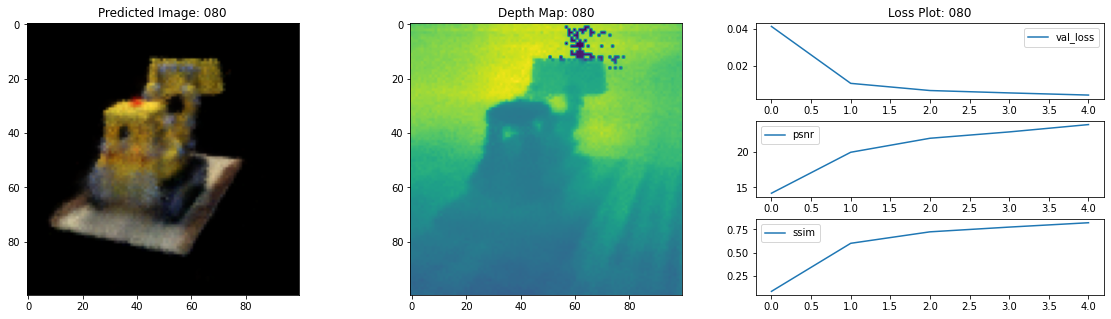

Epoch 82/500
16/16 [==============================] - 59s 4s/step - loss: 0.0042 - psnr: 23.8833 - ssim: 0.8220 - val_loss: 0.0048 - val_psnr: 23.3007 - val_ssim: 0.8050
Epoch 83/500
16/16 [==============================] - 56s 3s/step - loss: 0.0044 - psnr: 23.6783 - ssim: 0.8233 - val_loss: 0.0049 - val_psnr: 23.1890 - val_ssim: 0.8003
Epoch 84/500
16/16 [==============================] - 57s 3s/step - loss: 0.0043 - psnr: 23.8526 - ssim: 0.8200 - val_loss: 0.0048 - val_psnr: 23.3264 - val_ssim: 0.8070
Epoch 85/500
16/16 [==============================] - 56s 3s/step - loss: 0.0042 - psnr: 23.9462 - ssim: 0.8252 - val_loss: 0.0047 - val_psnr: 23.4525 - val_ssim: 0.8091
Epoch 86/500
16/16 [==============================] - 56s 3s/step - loss: 0.0042 - psnr: 23.9576 - ssim: 0.8278 - val_loss: 0.0047 - val_psnr: 23.3607 - val_ssim: 0.8112
Epoch 87/500
16/16 [==============================] - 55s 3s/step - loss: 0.0043 - psnr: 23.8685 - ssim: 0.8291 - val_loss: 0.0050 - val_psnr: 23.1672

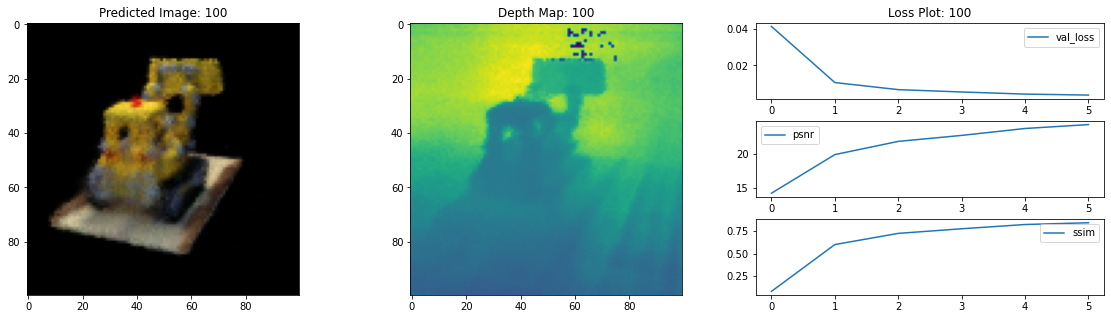

Epoch 102/500
16/16 [==============================] - 56s 3s/step - loss: 0.0037 - psnr: 24.4691 - ssim: 0.8430 - val_loss: 0.0044 - val_psnr: 23.7621 - val_ssim: 0.8191
Epoch 103/500
16/16 [==============================] - 57s 3s/step - loss: 0.0038 - psnr: 24.3301 - ssim: 0.8421 - val_loss: 0.0045 - val_psnr: 23.5861 - val_ssim: 0.8155
Epoch 104/500
16/16 [==============================] - 56s 3s/step - loss: 0.0039 - psnr: 24.2905 - ssim: 0.8386 - val_loss: 0.0044 - val_psnr: 23.6688 - val_ssim: 0.8195
Epoch 105/500
16/16 [==============================] - 56s 3s/step - loss: 0.0038 - psnr: 24.4003 - ssim: 0.8421 - val_loss: 0.0042 - val_psnr: 23.8701 - val_ssim: 0.8255
Epoch 106/500
16/16 [==============================] - 56s 3s/step - loss: 0.0037 - psnr: 24.5022 - ssim: 0.8455 - val_loss: 0.0043 - val_psnr: 23.8090 - val_ssim: 0.8262
Epoch 107/500
16/16 [==============================] - 56s 3s/step - loss: 0.0037 - psnr: 24.4369 - ssim: 0.8445 - val_loss: 0.0041 - val_psnr: 2

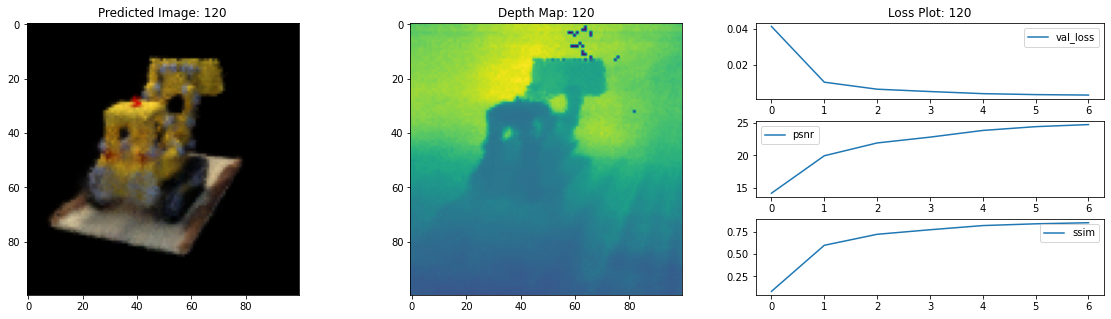

Epoch 122/500
16/16 [==============================] - 57s 3s/step - loss: 0.0036 - psnr: 24.6497 - ssim: 0.8541 - val_loss: 0.0040 - val_psnr: 24.1508 - val_ssim: 0.8338
Epoch 123/500
16/16 [==============================] - 56s 3s/step - loss: 0.0035 - psnr: 24.6717 - ssim: 0.8536 - val_loss: 0.0040 - val_psnr: 24.1345 - val_ssim: 0.8362
Epoch 124/500
16/16 [==============================] - 57s 3s/step - loss: 0.0035 - psnr: 24.7544 - ssim: 0.8558 - val_loss: 0.0039 - val_psnr: 24.2431 - val_ssim: 0.8397
Epoch 125/500
16/16 [==============================] - 57s 3s/step - loss: 0.0035 - psnr: 24.7501 - ssim: 0.8544 - val_loss: 0.0040 - val_psnr: 24.1797 - val_ssim: 0.8375
Epoch 126/500
16/16 [==============================] - 55s 3s/step - loss: 0.0035 - psnr: 24.7832 - ssim: 0.8556 - val_loss: 0.0040 - val_psnr: 24.1658 - val_ssim: 0.8357
Epoch 127/500
16/16 [==============================] - 57s 3s/step - loss: 0.0035 - psnr: 24.7599 - ssim: 0.8558 - val_loss: 0.0042 - val_psnr: 2

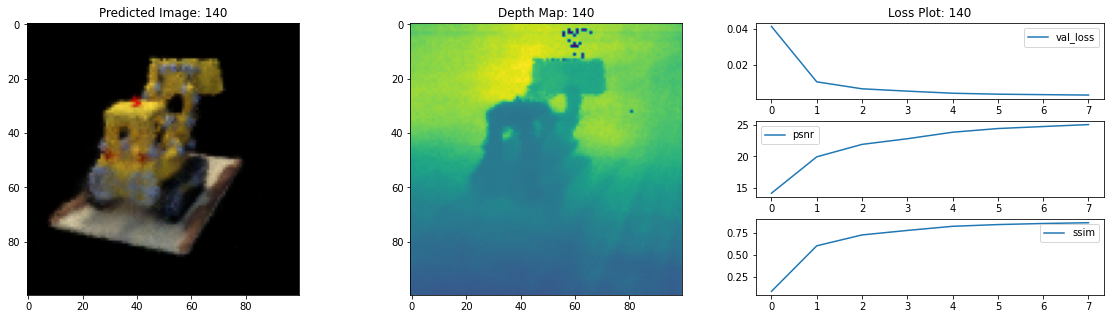

Epoch 142/500
16/16 [==============================] - 59s 4s/step - loss: 0.0033 - psnr: 25.0185 - ssim: 0.8629 - val_loss: 0.0037 - val_psnr: 24.4454 - val_ssim: 0.8471
Epoch 143/500
16/16 [==============================] - 59s 4s/step - loss: 0.0034 - psnr: 24.8325 - ssim: 0.8620 - val_loss: 0.0039 - val_psnr: 24.3294 - val_ssim: 0.8430
Epoch 144/500
16/16 [==============================] - 56s 3s/step - loss: 0.0034 - psnr: 24.8652 - ssim: 0.8616 - val_loss: 0.0040 - val_psnr: 24.2036 - val_ssim: 0.8418
Epoch 145/500
16/16 [==============================] - 56s 3s/step - loss: 0.0035 - psnr: 24.7800 - ssim: 0.8599 - val_loss: 0.0040 - val_psnr: 24.1613 - val_ssim: 0.8352
Epoch 146/500
16/16 [==============================] - 56s 3s/step - loss: 0.0034 - psnr: 24.8362 - ssim: 0.8602 - val_loss: 0.0042 - val_psnr: 23.8480 - val_ssim: 0.8326
Epoch 147/500
16/16 [==============================] - 56s 3s/step - loss: 0.0034 - psnr: 24.8487 - ssim: 0.8588 - val_loss: 0.0039 - val_psnr: 2

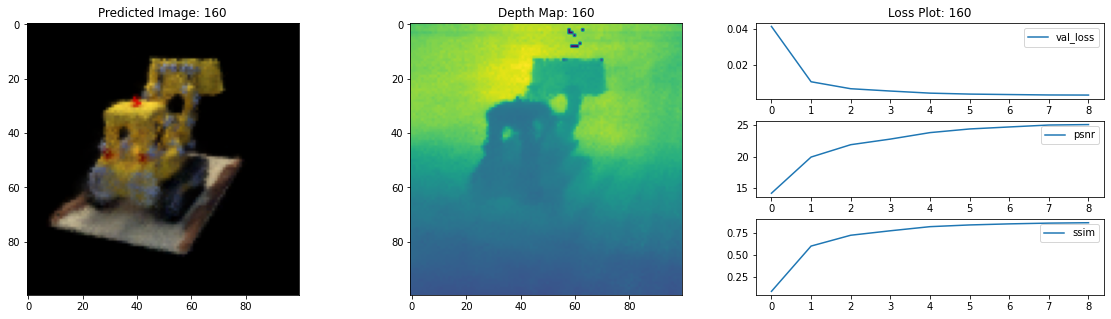

Epoch 162/500
16/16 [==============================] - 55s 3s/step - loss: 0.0033 - psnr: 24.9985 - ssim: 0.8634 - val_loss: 0.0038 - val_psnr: 24.3437 - val_ssim: 0.8460
Epoch 163/500
16/16 [==============================] - 57s 3s/step - loss: 0.0032 - psnr: 25.1356 - ssim: 0.8679 - val_loss: 0.0038 - val_psnr: 24.3373 - val_ssim: 0.8468
Epoch 164/500
16/16 [==============================] - 57s 3s/step - loss: 0.0032 - psnr: 25.1883 - ssim: 0.8680 - val_loss: 0.0036 - val_psnr: 24.6290 - val_ssim: 0.8506
Epoch 165/500
16/16 [==============================] - 56s 3s/step - loss: 0.0032 - psnr: 25.1552 - ssim: 0.8684 - val_loss: 0.0038 - val_psnr: 24.3835 - val_ssim: 0.8455
Epoch 166/500
16/16 [==============================] - 56s 3s/step - loss: 0.0032 - psnr: 25.1624 - ssim: 0.8693 - val_loss: 0.0037 - val_psnr: 24.4550 - val_ssim: 0.8499
Epoch 167/500
16/16 [==============================] - 56s 3s/step - loss: 0.0031 - psnr: 25.2200 - ssim: 0.8686 - val_loss: 0.0038 - val_psnr: 2

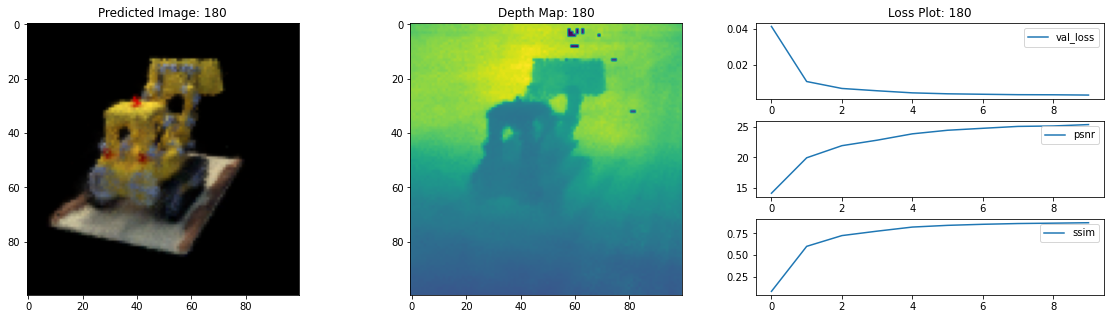

Epoch 182/500
16/16 [==============================] - 58s 4s/step - loss: 0.0032 - psnr: 25.2042 - ssim: 0.8708 - val_loss: 0.0040 - val_psnr: 24.1714 - val_ssim: 0.8440
Epoch 183/500
16/16 [==============================] - 58s 3s/step - loss: 0.0033 - psnr: 24.9476 - ssim: 0.8669 - val_loss: 0.0038 - val_psnr: 24.3185 - val_ssim: 0.8452
Epoch 184/500
16/16 [==============================] - 57s 3s/step - loss: 0.0032 - psnr: 25.1674 - ssim: 0.8690 - val_loss: 0.0036 - val_psnr: 24.6108 - val_ssim: 0.8503
Epoch 185/500
16/16 [==============================] - 57s 3s/step - loss: 0.0032 - psnr: 25.0899 - ssim: 0.8700 - val_loss: 0.0038 - val_psnr: 24.4466 - val_ssim: 0.8510
Epoch 186/500
16/16 [==============================] - 57s 3s/step - loss: 0.0031 - psnr: 25.2280 - ssim: 0.8719 - val_loss: 0.0036 - val_psnr: 24.5740 - val_ssim: 0.8521
Epoch 187/500
16/16 [==============================] - 59s 4s/step - loss: 0.0031 - psnr: 25.2621 - ssim: 0.8707 - val_loss: 0.0036 - val_psnr: 2

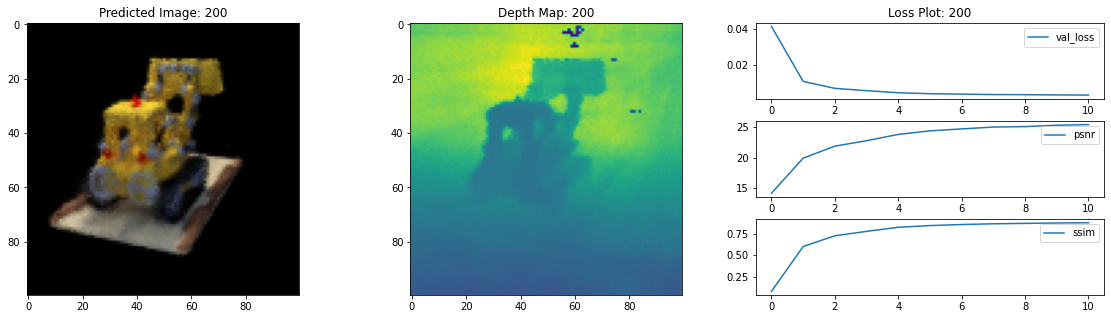

Epoch 202/500
16/16 [==============================] - 59s 4s/step - loss: 0.0030 - psnr: 25.3871 - ssim: 0.8750 - val_loss: 0.0036 - val_psnr: 24.6340 - val_ssim: 0.8553
Epoch 203/500
16/16 [==============================] - 58s 3s/step - loss: 0.0030 - psnr: 25.3777 - ssim: 0.8746 - val_loss: 0.0036 - val_psnr: 24.6091 - val_ssim: 0.8523
Epoch 204/500
16/16 [==============================] - 58s 3s/step - loss: 0.0030 - psnr: 25.3887 - ssim: 0.8753 - val_loss: 0.0036 - val_psnr: 24.5780 - val_ssim: 0.8539
Epoch 205/500
16/16 [==============================] - 58s 4s/step - loss: 0.0030 - psnr: 25.4040 - ssim: 0.8752 - val_loss: 0.0035 - val_psnr: 24.7108 - val_ssim: 0.8539
Epoch 206/500
16/16 [==============================] - 59s 4s/step - loss: 0.0031 - psnr: 25.3517 - ssim: 0.8738 - val_loss: 0.0035 - val_psnr: 24.7053 - val_ssim: 0.8564
Epoch 207/500
16/16 [==============================] - 58s 3s/step - loss: 0.0030 - psnr: 25.3844 - ssim: 0.8770 - val_loss: 0.0036 - val_psnr: 2

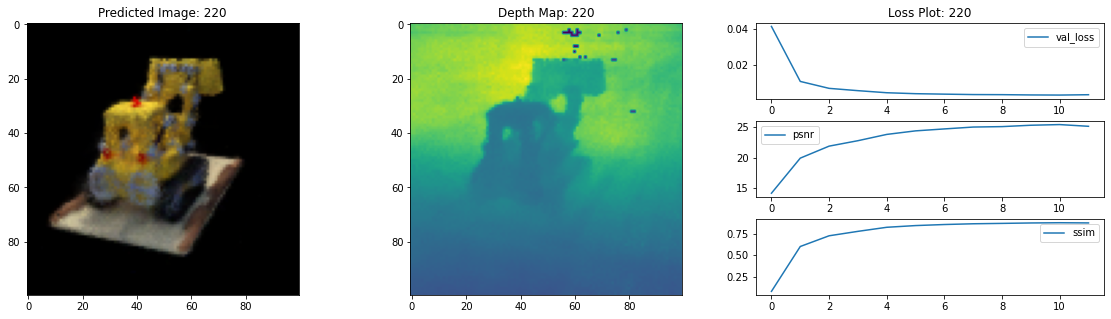

Epoch 222/500
16/16 [==============================] - 57s 3s/step - loss: 0.0031 - psnr: 25.3055 - ssim: 0.8731 - val_loss: 0.0036 - val_psnr: 24.6135 - val_ssim: 0.8562
Epoch 223/500
16/16 [==============================] - 58s 3s/step - loss: 0.0030 - psnr: 25.4086 - ssim: 0.8769 - val_loss: 0.0037 - val_psnr: 24.4875 - val_ssim: 0.8533
Epoch 224/500
16/16 [==============================] - 58s 4s/step - loss: 0.0029 - psnr: 25.5746 - ssim: 0.8774 - val_loss: 0.0035 - val_psnr: 24.7419 - val_ssim: 0.8575
Epoch 225/500
16/16 [==============================] - 59s 4s/step - loss: 0.0029 - psnr: 25.5255 - ssim: 0.8774 - val_loss: 0.0036 - val_psnr: 24.6781 - val_ssim: 0.8566
Epoch 226/500
16/16 [==============================] - 59s 4s/step - loss: 0.0029 - psnr: 25.5449 - ssim: 0.8777 - val_loss: 0.0035 - val_psnr: 24.7388 - val_ssim: 0.8586
Epoch 227/500
16/16 [==============================] - 58s 4s/step - loss: 0.0029 - psnr: 25.5186 - ssim: 0.8797 - val_loss: 0.0036 - val_psnr: 2

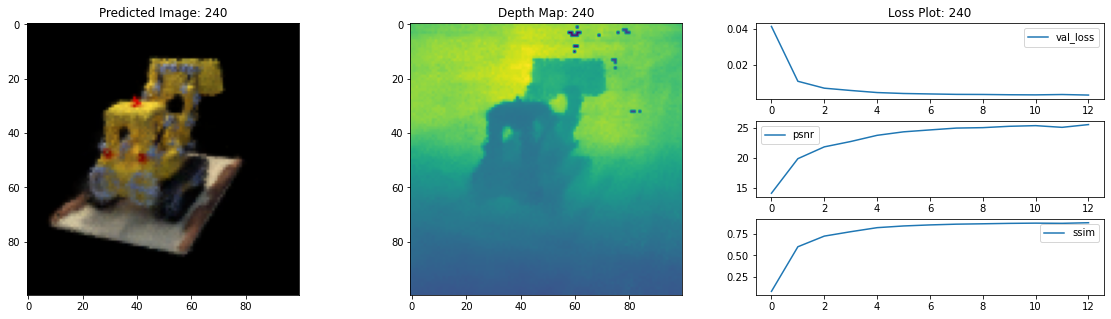

Epoch 242/500
16/16 [==============================] - 56s 3s/step - loss: 0.0028 - psnr: 25.6419 - ssim: 0.8799 - val_loss: 0.0036 - val_psnr: 24.5533 - val_ssim: 0.8533
Epoch 243/500
16/16 [==============================] - 57s 3s/step - loss: 0.0029 - psnr: 25.5816 - ssim: 0.8787 - val_loss: 0.0036 - val_psnr: 24.6556 - val_ssim: 0.8582
Epoch 244/500
16/16 [==============================] - 57s 3s/step - loss: 0.0030 - psnr: 25.4419 - ssim: 0.8801 - val_loss: 0.0037 - val_psnr: 24.5716 - val_ssim: 0.8557
Epoch 245/500
16/16 [==============================] - 56s 3s/step - loss: 0.0030 - psnr: 25.4062 - ssim: 0.8786 - val_loss: 0.0035 - val_psnr: 24.6948 - val_ssim: 0.8560
Epoch 246/500
16/16 [==============================] - 58s 4s/step - loss: 0.0030 - psnr: 25.3927 - ssim: 0.8781 - val_loss: 0.0038 - val_psnr: 24.3570 - val_ssim: 0.8525
Epoch 247/500
16/16 [==============================] - 58s 3s/step - loss: 0.0030 - psnr: 25.4813 - ssim: 0.8773 - val_loss: 0.0035 - val_psnr: 2

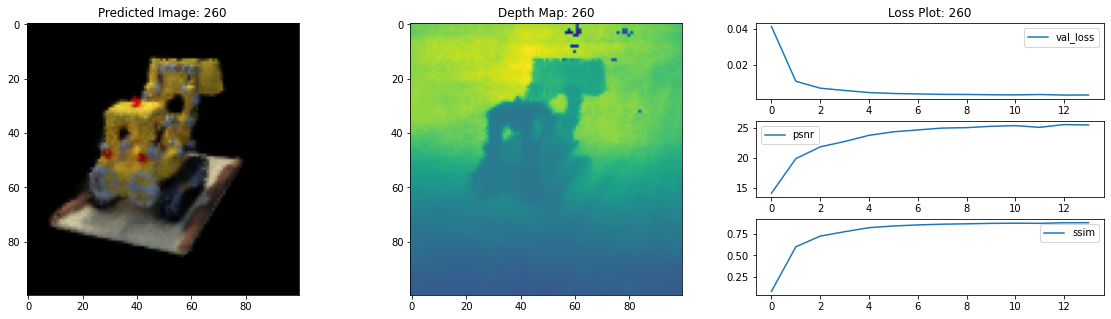

Epoch 262/500
16/16 [==============================] - 57s 3s/step - loss: 0.0030 - psnr: 25.4677 - ssim: 0.8805 - val_loss: 0.0034 - val_psnr: 24.8824 - val_ssim: 0.8557
Epoch 263/500
16/16 [==============================] - 56s 3s/step - loss: 0.0029 - psnr: 25.5239 - ssim: 0.8808 - val_loss: 0.0035 - val_psnr: 24.6864 - val_ssim: 0.8550
Epoch 264/500
16/16 [==============================] - 58s 4s/step - loss: 0.0029 - psnr: 25.5979 - ssim: 0.8787 - val_loss: 0.0036 - val_psnr: 24.5737 - val_ssim: 0.8564
Epoch 265/500
16/16 [==============================] - 58s 3s/step - loss: 0.0029 - psnr: 25.6055 - ssim: 0.8788 - val_loss: 0.0036 - val_psnr: 24.6052 - val_ssim: 0.8556
Epoch 266/500
16/16 [==============================] - 59s 4s/step - loss: 0.0028 - psnr: 25.6931 - ssim: 0.8813 - val_loss: 0.0034 - val_psnr: 24.8552 - val_ssim: 0.8628
Epoch 267/500
16/16 [==============================] - 58s 3s/step - loss: 0.0029 - psnr: 25.5683 - ssim: 0.8823 - val_loss: 0.0034 - val_psnr: 2

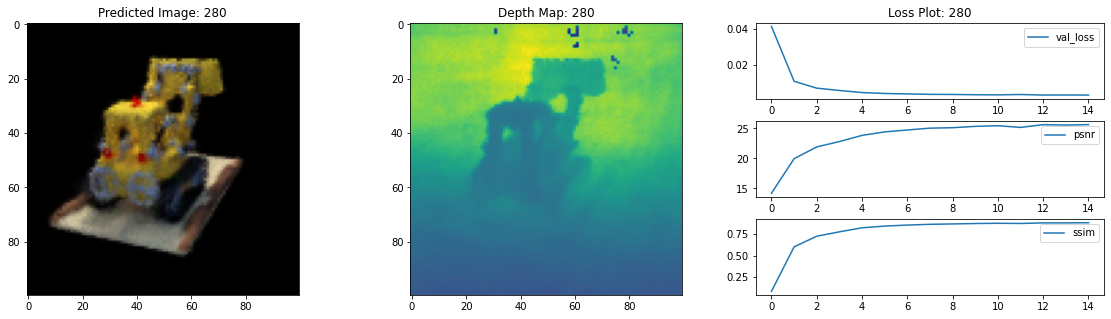

Epoch 282/500
16/16 [==============================] - 59s 4s/step - loss: 0.0029 - psnr: 25.5713 - ssim: 0.8813 - val_loss: 0.0035 - val_psnr: 24.8234 - val_ssim: 0.8613
Epoch 283/500
16/16 [==============================] - 59s 4s/step - loss: 0.0028 - psnr: 25.6564 - ssim: 0.8839 - val_loss: 0.0036 - val_psnr: 24.6312 - val_ssim: 0.8576
Epoch 284/500
16/16 [==============================] - 59s 4s/step - loss: 0.0030 - psnr: 25.4506 - ssim: 0.8789 - val_loss: 0.0038 - val_psnr: 24.4102 - val_ssim: 0.8535
Epoch 285/500
16/16 [==============================] - 59s 4s/step - loss: 0.0030 - psnr: 25.3537 - ssim: 0.8788 - val_loss: 0.0035 - val_psnr: 24.7255 - val_ssim: 0.8561
Epoch 286/500
16/16 [==============================] - 60s 4s/step - loss: 0.0028 - psnr: 25.6532 - ssim: 0.8802 - val_loss: 0.0034 - val_psnr: 24.8264 - val_ssim: 0.8605
Epoch 287/500
16/16 [==============================] - 59s 4s/step - loss: 0.0028 - psnr: 25.7076 - ssim: 0.8809 - val_loss: 0.0034 - val_psnr: 2

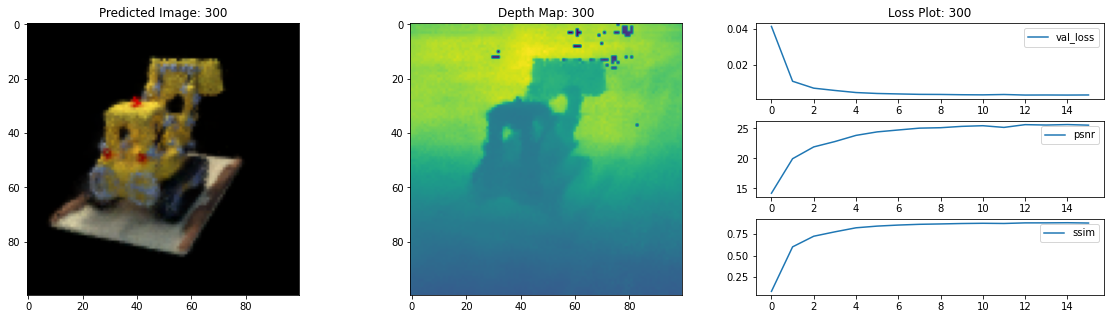

Epoch 302/500
16/16 [==============================] - 61s 4s/step - loss: 0.0028 - psnr: 25.7284 - ssim: 0.8804 - val_loss: 0.0037 - val_psnr: 24.5086 - val_ssim: 0.8534
Epoch 303/500
16/16 [==============================] - 61s 4s/step - loss: 0.0029 - psnr: 25.6140 - ssim: 0.8801 - val_loss: 0.0036 - val_psnr: 24.5965 - val_ssim: 0.8599
Epoch 304/500
16/16 [==============================] - 62s 4s/step - loss: 0.0029 - psnr: 25.5754 - ssim: 0.8807 - val_loss: 0.0037 - val_psnr: 24.4703 - val_ssim: 0.8601
Epoch 305/500
16/16 [==============================] - 60s 4s/step - loss: 0.0028 - psnr: 25.6754 - ssim: 0.8831 - val_loss: 0.0037 - val_psnr: 24.5635 - val_ssim: 0.8591
Epoch 306/500
16/16 [==============================] - 61s 4s/step - loss: 0.0029 - psnr: 25.5359 - ssim: 0.8821 - val_loss: 0.0046 - val_psnr: 23.6352 - val_ssim: 0.8561
Epoch 307/500
16/16 [==============================] - 60s 4s/step - loss: 0.0030 - psnr: 25.4765 - ssim: 0.8809 - val_loss: 0.0035 - val_psnr: 2

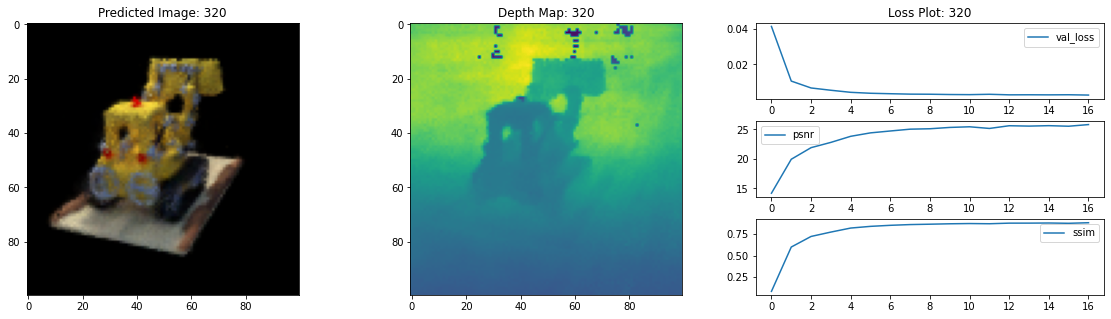

Epoch 322/500
16/16 [==============================] - 61s 4s/step - loss: 0.0027 - psnr: 25.8595 - ssim: 0.8838 - val_loss: 0.0035 - val_psnr: 24.8081 - val_ssim: 0.8626
Epoch 323/500
16/16 [==============================] - 60s 4s/step - loss: 0.0028 - psnr: 25.7828 - ssim: 0.8844 - val_loss: 0.0035 - val_psnr: 24.6871 - val_ssim: 0.8568
Epoch 324/500
16/16 [==============================] - 59s 4s/step - loss: 0.0028 - psnr: 25.7612 - ssim: 0.8848 - val_loss: 0.0035 - val_psnr: 24.7112 - val_ssim: 0.8622
Epoch 325/500
16/16 [==============================] - 60s 4s/step - loss: 0.0028 - psnr: 25.7303 - ssim: 0.8838 - val_loss: 0.0036 - val_psnr: 24.6501 - val_ssim: 0.8618
Epoch 326/500
16/16 [==============================] - 60s 4s/step - loss: 0.0029 - psnr: 25.6257 - ssim: 0.8836 - val_loss: 0.0036 - val_psnr: 24.6028 - val_ssim: 0.8569
Epoch 327/500
16/16 [==============================] - 60s 4s/step - loss: 0.0030 - psnr: 25.4154 - ssim: 0.8797 - val_loss: 0.0036 - val_psnr: 2

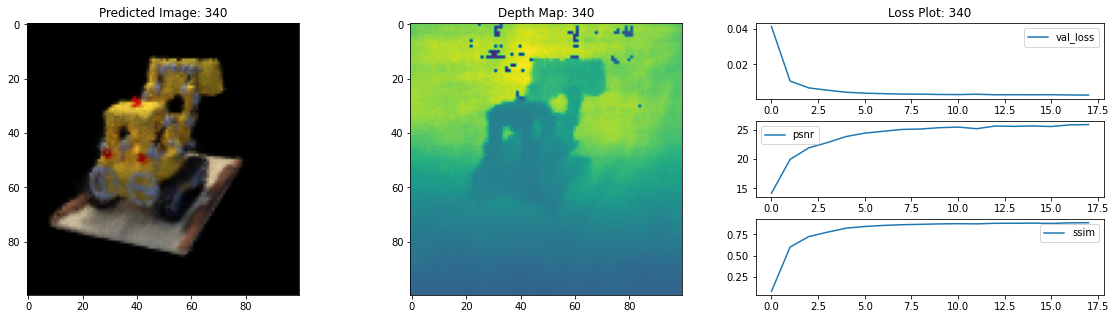

Epoch 342/500
16/16 [==============================] - 61s 4s/step - loss: 0.0027 - psnr: 25.8436 - ssim: 0.8866 - val_loss: 0.0035 - val_psnr: 24.7266 - val_ssim: 0.8638
Epoch 343/500
16/16 [==============================] - 61s 4s/step - loss: 0.0028 - psnr: 25.8099 - ssim: 0.8849 - val_loss: 0.0037 - val_psnr: 24.5492 - val_ssim: 0.8582


In [21]:
loss_list,PSNR_list,SSIM_list = [],[],[]

model.fit(train_ds,validation_data=val_ds,
    batch_size=5,
    epochs=500,
    callbacks=[TrainMonitor(),ckpt,es], #과적합 방지 사전조치 es(early_stopping)
    steps_per_epoch=split_index // 5,)

In [ ]:
latest = tf.train.latest_checkpoints('./checkpoints')
model.load_weight(latest)

In [ ]:
create_gif("images/*.png" , "training.gif")

In [ ]:
def get_im_loss(images,rgb):
    psnr = tf.image.psnr(images, rgb, max_val=1.0)
    ssim = tf.image.ssim(images, rgb, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    return psnr, ssim

In [ ]:
test_recons_images, depth_maps = render_rgb_depth(
                model=model
                rays_flat=test_rays_flat,
                t_vals=test_t_vals,
                rand=True,
                train=False)